In [1]:
from RewardingVisualDoubt import mimic_cxr  # dataset, inference, prompter, shared, vllm

In [2]:
mimic_cxr_df = mimic_cxr.create_mimic_cxr_dataset_df()

mimic_cxr_df.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,dicom_id,split,img_path
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
1,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
2,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
3,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
4,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...


In [ ]:
import pandas as pd

split_df = pd.read_csv(mimic_cxr.MIMIC_CXR_SPLIT_CSV_PATH)
print("Train split size:", sum(split_df["split"] == "train"))
print("Val split size:", sum(split_df["split"] == "validate"))
print("Test split size:", sum(split_df["split"] == "test"))

print("Total dataset size:", len(split_df))

Train split size: 368960
Val split size: 2991
Test split size: 5159
Total dataset size: 377110


In [6]:
mimic_cxr_df["Lung Lesion"].value_counts()

Lung Lesion
 1.0    10801
-1.0     2027
 0.0     1719
Name: count, dtype: int64

In [7]:
mimic_cxr_df.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'img_path'],
      dtype='object')

In [21]:
disease_cols = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Enlarged Cardiomediastinum",
    "Fracture",
    "Lung Lesion",
    "Lung Opacity",
    "Pleural Effusion",
    "Pleural Other",
    "Pneumonia",
    "Pneumothorax",
    "Support Devices",
]

# Melt the dataframe so that each row now corresponds to one disease label
df_melt = mimic_cxr_df.melt(
    id_vars=["subject_id", "study_id", "dicom_id", "split", "img_path"],
    value_vars=disease_cols,
    var_name="disease",
    value_name="label",
)

# Keep only rows with confident labels (i.e. label 1.0 or 0.0)
df_melt = df_melt[df_melt["label"].isin([0.0, 1.0])].copy()

# Convert labels to booleans: 1.0 -> True (disease present), 0.0 -> False (disease absent)
df_melt["label"] = df_melt["label"].astype(bool)

In [22]:
import pandas as pd

# Now, to balance the dataset for each disease:
balanced_dfs = []
for disease in df_melt["disease"].unique():
    sub_df = df_melt[df_melt["disease"] == disease]
    pos = sub_df[sub_df["label"] == True]
    neg = sub_df[sub_df["label"] == False]

    # Determine the number of samples to draw from each class
    n_samples = min(len(pos), len(neg))

    # Only balance if both classes have at least one sample
    if n_samples > 0:
        pos_balanced = pos.sample(n=n_samples, random_state=42)
        neg_balanced = neg.sample(n=n_samples, random_state=42)

        balanced_sub = pd.concat([pos_balanced, neg_balanced])
        balanced_dfs.append(balanced_sub)

# Combine the balanced data for all diseases into one dataframe
balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)

# Optionally, shuffle the final balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.head()

,subject_id,study_id,dicom_id,split,img_path,disease,label
0,12482083,59343074,8b4e9433-3f2174ba-0511c4fd-1fc2e8ad-0200da51,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,True
1,15341255,54667338,8093269d-c8faa661-fd9e8283-d061e248-bc4ff015,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pneumonia,False
2,11503732,59347795,a4c764ca-6212e343-3b8be8ee-9a95202c-5d0f0290,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Enlarged Cardiomediastinum,True
3,19643214,50041888,07dc3125-e81056d9-cf3b883f-8dbce64a-c64193f7,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,False
4,13666616,54145574,1ad0729b-32bd8914-e0960255-584827b0-10b60349,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pneumonia,True


In [29]:
mimic_cxr_df[mimic_cxr_df["subject_id"] == 12482083]

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,dicom_id,split,img_path
93500,12482083,50858163,1.0,NaN,NaN,0.0,-1.0,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,0.0,1.0,2f0cd741-10dc500a-c06792e3-32b8d84f-53b1edae,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93501,12482083,51137305,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,9611b83c-593271f8-fc3d0d89-6c172cc0-fdaa79a9,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93502,12482083,51154849,1.0,NaN,NaN,NaN,-1.0,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,0.0,0.0,cdc661f8-0fe9a78f-fbfa2887-4e54e3b8-84d8565e,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93503,12482083,52201511,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,70f7fc00-ed8e25ac-27d975bf-df1d6d6d-04d8e18f,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93504,12482083,53159817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,b42188f0-5556f30b-7c5e7ef8-b2462bdb-697ff8b2,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93505,12482083,54250319,-1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,a0911cc0-3e372be4-bbd42805-71db6bdc-4d579b41,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93506,12482083,56556787,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6843b28c-b5b683ce-0d7a2a91-c02c30e4-dec576d9,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93507,12482083,56556787,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,8af98473-5f5b261c-a91fa8cd-590f0853-e06056e1,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93508,12482083,56817441,NaN,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,9fbec461-20f95c5a-6154bd68-3e2da8e6-ad0ccee3,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
93509,12482083,57218430,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,a449f855-328a69ce-23c660b6-4ec56707-dcb513d3,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...


In [26]:
balanced_df

,subject_id,study_id,dicom_id,split,img_path,disease,label
0,12482083,59343074,8b4e9433-3f2174ba-0511c4fd-1fc2e8ad-0200da51,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,True
1,15341255,54667338,8093269d-c8faa661-fd9e8283-d061e248-bc4ff015,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pneumonia,False
2,11503732,59347795,a4c764ca-6212e343-3b8be8ee-9a95202c-5d0f0290,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Enlarged Cardiomediastinum,True
3,19643214,50041888,07dc3125-e81056d9-cf3b883f-8dbce64a-c64193f7,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,False
4,13666616,54145574,1ad0729b-32bd8914-e0960255-584827b0-10b60349,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pneumonia,True
...,...,...,...,...,...,...,...
368985,14495561,58512001,0db9c762-818d9334-a6bc2073-9cf5f5e9-1bc1da5f,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,False
368986,15258714,59686944,6bee9d0c-b135b30d-0a3217af-773e91a0-193d210d,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Support Devices,False
368987,11050347,57689847,0b71ea43-f789c88f-03a77408-5f3c86bb-8f0a1679,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Edema,False
368988,10063534,54266862,66630da7-154c949e-888702d6-a79f3b1e-b6788117,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Edema,False


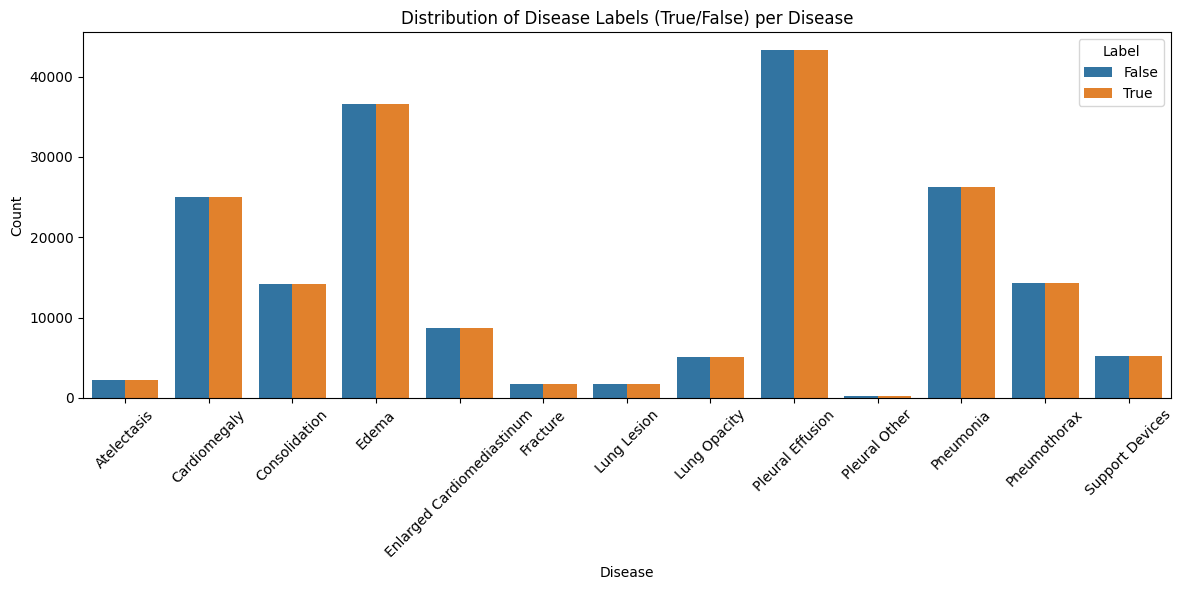

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=balanced_df, x="disease", hue="label", order=sorted(balanced_df["disease"].unique())
)

# Customize the plot
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels (True/False) per Disease")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.legend(title="Label", labels=["False", "True"])
plt.tight_layout()

# Display the plot
plt.show()

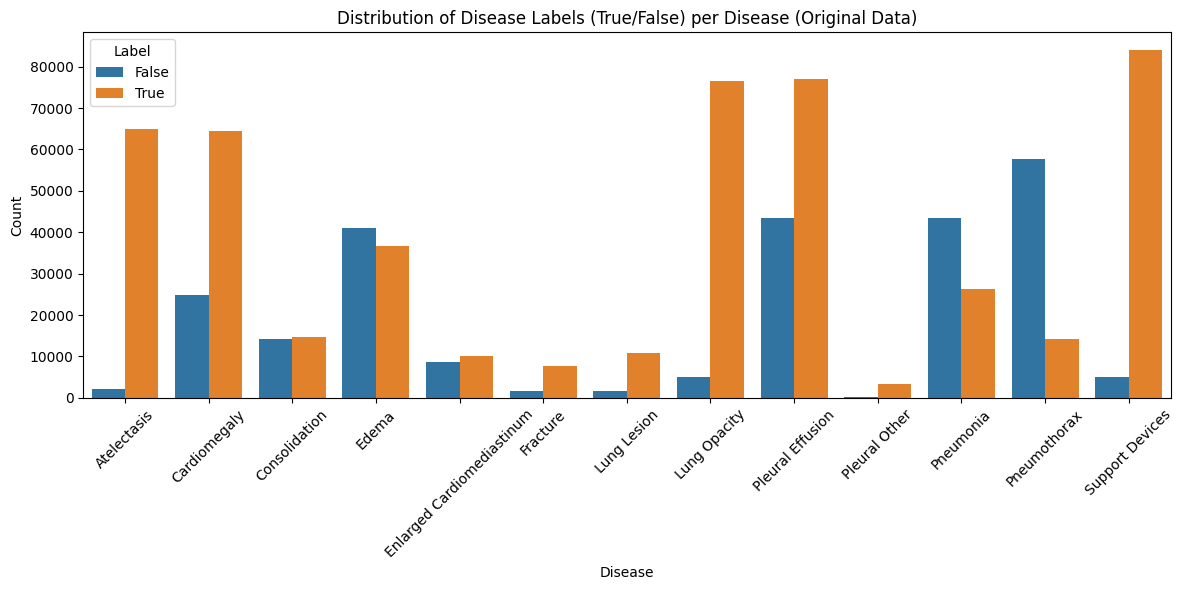

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the disease columns you want to analyze (excluding "No Finding")
disease_cols = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Enlarged Cardiomediastinum",
    "Fracture",
    "Lung Lesion",
    "Lung Opacity",
    "Pleural Effusion",
    "Pleural Other",
    "Pneumonia",
    "Pneumothorax",
    "Support Devices",
]

# Melt the original dataframe so that each row corresponds to one disease label for a study
df_melt_orig = mimic_cxr_df.melt(
    id_vars=["subject_id", "study_id", "dicom_id", "split", "img_path"],
    value_vars=disease_cols,
    var_name="disease",
    value_name="label",
)

# Filter out uncertain (-1.0) and missing values, keeping only confident labels (1.0 and 0.0)
df_melt_orig_filtered = df_melt_orig[df_melt_orig["label"].isin([0.0, 1.0])].copy()

# Convert labels to booleans: 1.0 becomes True (disease present) and 0.0 becomes False (disease absent)
df_melt_orig_filtered["label"] = df_melt_orig_filtered["label"].astype(bool)

# Plot the distribution using Seaborn's countplot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_melt_orig_filtered,
    x="disease",
    hue="label",
    order=sorted(df_melt_orig_filtered["disease"].unique()),
)

# Customize the plot
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels (True/False) per Disease (Original Data)")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.legend(title="Label", labels=["False", "True"])
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
disease_cols

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Enlarged Cardiomediastinum',
 'Fracture',
 'Lung Lesion',
 'Lung Opacity',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the disease columns (excluding "No Finding")
# disease_cols = [
#     "Atelectasis",
#     "Cardiomegaly",
#     "Consolidation",
#     "Edema",
#     "Enlarged Cardiomediastinum",
#     "Fracture",
#     "Lung Lesion",
#     "Lung Opacity",
#     "Pleural Effusion",
#     "Pleural Other",
#     "Pneumonia",
#     "Pneumothorax",
#     "Support Devices",
# ]
disease_cols = [disease.value for disease in mimic_cxr.ChexpertFinding]
disease_cols.pop(disease_cols.index("No Finding"))

# Melt the original dataframe so that each row corresponds to one disease label for a study
df_melt = mimic_cxr_df.melt(
    id_vars=["subject_id", "study_id", "dicom_id", "split", "img_path"],
    value_vars=disease_cols,
    var_name="disease",
    value_name="label",
)

# Filter out uncertain (-1.0) and missing values; keep only confident labels (1.0 and 0.0)
df_melt = df_melt[df_melt["label"].isin([0.0, 1.0])].copy()

# Convert labels to booleans (1.0 becomes True, 0.0 becomes False)
df_melt["label"] = df_melt["label"].astype(bool)

# For each disease, oversample the minority class so that positives and negatives are balanced
balanced_dfs = []
for disease in df_melt["disease"].unique():
    sub_df = df_melt[df_melt["disease"] == disease]
    pos = sub_df[sub_df["label"] == True]
    neg = sub_df[sub_df["label"] == False]

    # Oversample the minority class using replacement
    if len(pos) > len(neg):
        neg_balanced = neg.sample(n=len(pos), replace=True, random_state=42)
        balanced_sub = pd.concat([pos, neg_balanced])
    elif len(neg) > len(pos):
        pos_balanced = pos.sample(n=len(neg), replace=True, random_state=42)
        balanced_sub = pd.concat([neg, pos_balanced])
    else:
        balanced_sub = sub_df  # Already balanced
    balanced_dfs.append(balanced_sub)

# Combine all diseases into one dataframe and shuffle it
balanced_df_oversampled = pd.concat(balanced_dfs).reset_index(drop=True)
balanced_df_oversampled = balanced_df_oversampled.sample(frac=1, random_state=42).reset_index(
    drop=True
)

# Plot the distribution of disease labels for the new oversampled dataset
plt.figure(figsize=(12, 6))
sns.countplot(
    data=balanced_df_oversampled,
    x="disease",
    hue="label",
    order=sorted(balanced_df_oversampled["disease"].unique()),
)
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels (True/False) per Disease (Oversampled)")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.legend(title="Label", labels=["False", "True"])
plt.tight_layout()
plt.show()

NameError: name 'mimic_cxr_df' is not defined

In [2]:
mimic_cxr_df = mimic_cxr.create_mimic_cxr_dataset_df()
balanced_binary_qa_mimic_cxr_df = mimic_cxr.create_balanced_binary_qa_mimic_cxr_dataset_df(
    mimic_cxr_df
)

In [13]:
mimic_cxr_df[(mimic_cxr_df["subject_id"] == 14067967) & (mimic_cxr_df["study_id"] == 59655697)]

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,dicom_id,split,img_path
152958,14067967,59655697,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,0.0,1.0,095c8a6a-30065702-64308b3a-a839f0eb-5301c3d7,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
152959,14067967,59655697,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,0.0,1.0,fe1cb636-3fb99d4e-fe8f06f5-bd3e7afc-a7072a7d,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...


In [4]:
balanced_binary_qa_mimic_cxr_df.head()

,subject_id,study_id,dicom_id,split,img_path,disease,label
0,18022558,51386008,a14ea7b3-7a3eccb7-8bb066df-ce165f26-c94ba579,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,False
1,10908761,57569366,67decbc5-2dd8eadc-4c49969f-b8feda0d-1331f42f,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,True
2,19735084,54482907,89915e15-cc90a8ff-707bca71-763cf4a8-680b8cd9,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,False
3,15643451,59921408,6b3a908d-f777d1e7-b05dc43c-7b0d0e53-a05e429a,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pleural Effusion,False
4,14067967,59655697,fe1cb636-3fb99d4e-fe8f06f5-bd3e7afc-a7072a7d,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Pneumonia,False
